# Blood cells classification through deep learning


---



## Summary:

In this activity, we addressed the problem of blood cell classification. Initially, an exploratory analysis was conducted to better understand the nature of the data and the distribution of classes.

Next, we began creating a simple multi-layer perceptron (MLP) with only one hidden layer. We tested various parameters to select the optimal model, discussing data normalization, activation function selection, optimizers, batch normalization, and regularization. With these choices, we started designing the network architecture, selecting the number of neurons that best fit the model, using validation accuracy and computational performance as metrics. We also discussed the use of cross-validation and whether the improvement in model performance justified the significant increase in computational processing time. Early stopping was also addressed, along with the use of Dropout to make the model more robust. As a result, an optimal simple MLP was constructed, achieving an accuracy of 84% on the test data.

The same procedure was applied to an MLP with two hidden layers. Again, parameters were evaluated to achieve the best performance, resulting in an accuracy of 85% with this network. It was observed that most errors occurred when the network incorrectly classified class 3.

Subsequently, a simple one-layer convolutional neural network (CNN) was developed, and all optimization parameters were tested, including the number of filters (kernels), kernel sizes in the convolutional layer, and the pooling size in the max-pooling layer. This model achieved an accuracy of 88% on the test data.

Overall, MLPs and CNNs effectively handle the blood cell classification problem, and with further investigation, it is possible to improve network learning to achieve even better performance.

---



## Dataset

The dataset used is BloodMNIST (Acevedo et al., 2020, Yang et al., 2021), which contains 17,092 color microscopic images (3 color channels) with a dimension of 28 × 28 pixels.

Each class is labeled with non-negative integers, as described in Table 1.

| Label | Cell Type                |
|-------|--------------------------|
| 0     | Basophils                |
| 1     | Eosinophils              |
| 2     | Erythroblasts            |
| 3     | Immature Granulocytes    |
| 4     | Lymphocytes              |
| 5     | Monocytes                |
| 6     | Neutrophils              |
| 7     | Platelets                |

The dataset is divided into training, validation, and test sets in a 7:1:2 ratio. Although the group considers that cross-validation would be more appropriate as it increases the model's robustness, we will demonstrate in the next section that the time required to perform cross-validation is excessively high, even for the simplest model. Therefore, throughout the report, we will adhere to the data distribution used in BloodMNIST.

### Installing and loading packages

In [2]:
!pip install medmnist
!pip install keras-tuner --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_c

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
import medmnist
from medmnist import INFO, Evaluator
from sklearn import metrics
from sklearn.model_selection import KFold
from tensorflow import keras
from keras.optimizers import SGD
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Conv2D, MaxPooling2D, Conv3D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
from keras.layers import Input, Dense, Add
from keras.models import Model



### Loading data

In [4]:
data_flag = 'bloodmnist'
download = True

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

# load the data
train_dataset = DataClass(split='train', download=download)
test_dataset = DataClass(split='test', download=download)
validation_dataset = DataClass(split='val', download=download)

100%|██████████| 35461855/35461855 [00:00<00:00, 93897636.73it/s]


Using downloaded and verified file: /root/.medmnist/bloodmnist.npz
Using downloaded and verified file: /root/.medmnist/bloodmnist.npz


Checking data shape. There are 11959 images for training in a 28x28x3(RGB) format.

In [5]:
train_dataset.imgs.shape, train_dataset.labels.shape

((11959, 28, 28, 3), (11959, 1))

## EDA
### Class imbalance
To check the balance between classes, we counted the number of images for each class and data type, as shown in Figure 2. The dataset is clearly imbalanced, with class 1 being the most common, having over 2,000 training images, while class 4 is the least common, with fewer than 1,000 training images. Despite this, the class distribution in the test and validation data seems to follow the same pattern as the training data.

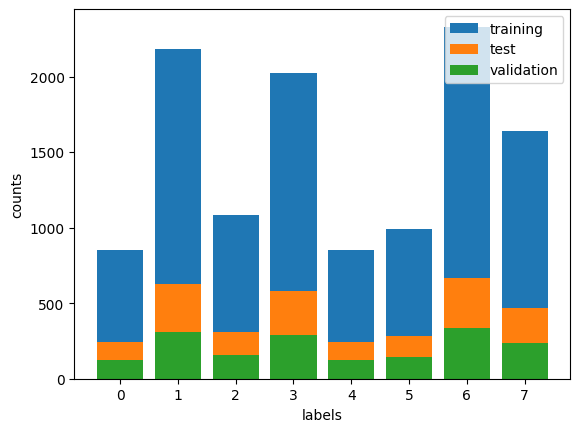

In [6]:
plt.figure(dpi=100)
unique, counts = np.unique(train_dataset.labels, return_counts=True)
plt.bar(unique,counts,label='training')
unique, counts = np.unique(test_dataset.labels, return_counts=True)
plt.bar(unique,counts,label='test')
unique, counts = np.unique(validation_dataset.labels, return_counts=True)
plt.bar(unique,counts,label='validation')
plt.legend()
plt.ylabel('counts')
plt.xlabel('labels')
plt.show()

### Transforming into numpy arrays and rescaling color-scale

In [7]:
X_train = []
y_train = []
for i in range (len(train_dataset)):
    x = train_dataset.imgs[i,:,:,:]
    y = train_dataset.labels[i]
    X_train.append(np.array(x)/255)
    y_train.append(y[0])

X_train = np.array(X_train)
y_train = to_categorical(np.array(y_train))

X_test = []
y_test = []
for i in range (len(test_dataset)):
    x = test_dataset.imgs[i,:,:,:]
    y = test_dataset.labels[i]
    X_test.append(np.array(x)/255)
    y_test.append(y[0])

X_test = np.array(X_test)
y_test = to_categorical(np.array(y_test))

X_val = []
y_val = []
for i in range (len(validation_dataset)):
    x = validation_dataset.imgs[i,:,:,:]
    y = validation_dataset.labels[i]
    X_val.append(np.array(x)/255)
    y_val.append(y[0])

X_val = np.array(X_val)
y_val = to_categorical(np.array(y_val))

### Example of microscope images

In [11]:
def get_cell_type(array):
    # Define the mapping of labels to cell types
    cell_types = [
        "Basophils",        # 0
        "Eosinophils",      # 1
        "Erythroblasts",    # 2
        "Immature Granulocytes",  # 3
        "Lymphocytes",      # 4
        "Monocytes",        # 5
        "Neutrophils",      # 6
        "Platelets"         # 7
    ]

    # Find the index of the maximum value in the array
    index = np.argmax(array)

    # Return the corresponding cell type
    return cell_types[index]

In [10]:
y_val[i]

array([0., 0., 0., 0., 0., 0., 1., 0.])

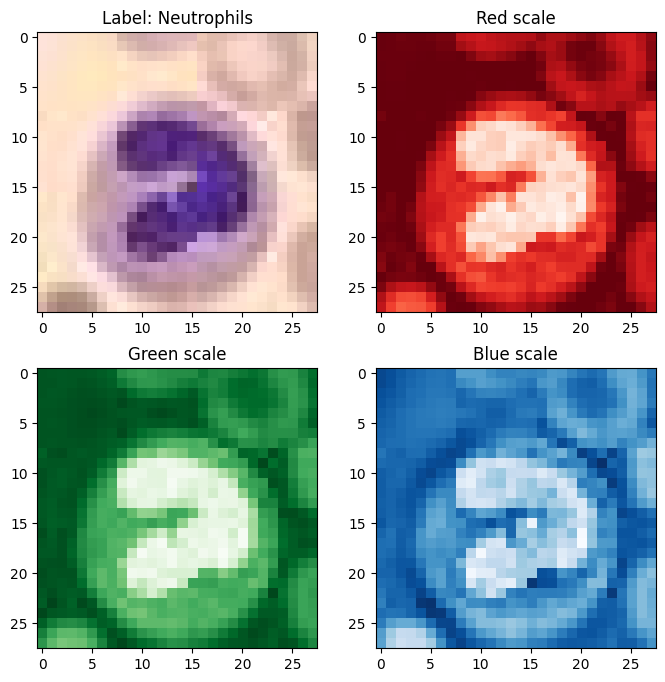

In [12]:
i = 101
plt.figure(figsize=(8,8))
plt.subplot(221)
plt.imshow(X_val[i])
plt.title('Label: '+get_cell_type(y_val[i]))
plt.subplot(222)
plt.title('Red scale')
plt.imshow(X_val[i][:,:,0],cmap='Reds')
plt.subplot(223)
plt.title('Green scale')
plt.imshow(X_val[i][:,:,1],cmap='Greens')
plt.subplot(224)
plt.title('Blue scale')
plt.imshow(X_val[i][:,:,2],cmap='Blues')
plt.show()

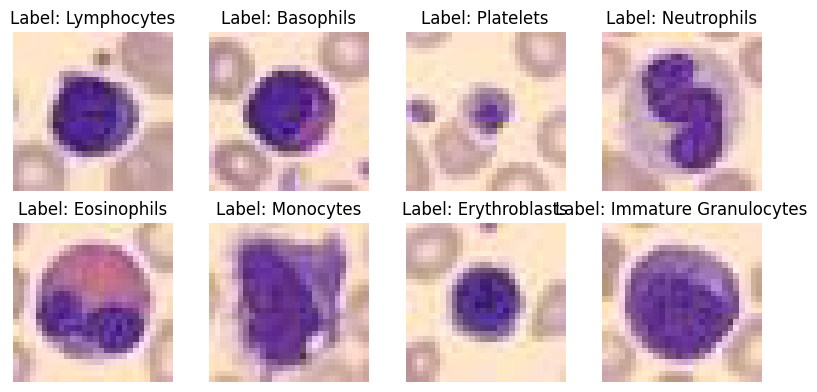

In [14]:
class_images = {}

# Iterate through the validation set to find one image for each class
for i in range(len(y_val)):
    class_label = get_cell_type(y_val[i])
    if class_label not in class_images:
        class_images[class_label] = X_val[i]

    # Break the loop if we have found one image for each of the 8 classes
    if len(class_images) == 8:
        break

# Create a figure with 2 rows and 4 columns
fig, axes = plt.subplots(2, 4, figsize=(8, 4))
for idx, (label, image) in enumerate(class_images.items()):
    row = idx // 4
    col = idx % 4
    axes[row, col].imshow(image)
    axes[row, col].set_title('Label: ' + label)
    axes[row, col].axis('off')
plt.tight_layout()
plt.show()

## Modeling with a single layered Percepetron

### Optmizing number of neurons
We started with a simple MLP network with a single layer of N neurons, ending with a softmax layer. The batch size and the total number of epochs were fixed at 64 and 32, respectively. We also used the Adam optimizer, along with EarlyStopping with a patience of 10 epochs and a tolerance of 0.001. Additionally, we applied batch normalization before the MLP's hidden layer (we will explore the effect of this normalization later). EarlyStopping was mainly used to prevent overfitting by monitoring accuracy variation. We had previously tested several activation functions, and since they showed similar performance, we chose ReLU. Batch normalization and Adam were selected because they demonstrated a faster learning rate.

In [15]:
def MLP_v2(X_tr,Y_tr,X_val,Y_val,n_neurons,n_hidden_layers,opt,num_classes=8,batch_size=64,epochs=32):
    #defining model
    model = Sequential()
    model.add(Flatten(input_shape=(28,28,3)))
    model.add(BatchNormalization())
    for i in range(n_hidden_layers):
      model.add(Dense(n_neurons, activation='relu'))
      model.add(Dropout(0.1))
    model.add(Dense(num_classes, activation='softmax'))
    # Compiling
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
    # Regularization with early stopping
    early_stopping = EarlyStopping(patience=10,min_delta=0.001,restore_best_weights=True,)
    # Fit and saving results
    history = model.fit(X_tr, Y_tr,
                      batch_size=batch_size,
                      epochs=epochs,
                      verbose=0,
                      validation_data=(X_val, Y_val),
                      callbacks=[early_stopping])
    scores = model.evaluate(X_val, Y_val, verbose=0)
    return scores, history

In [18]:
N = np.array([2,4,8,16,32,64,128,256,512])

S = []
H = []

for n_neurons in N:
  s, h = MLP_v2(X_train,y_train,X_val,y_val,n_neurons=n_neurons,n_hidden_layers=1,opt='adam')
  S.append(s)
  H.append(h)
  print('Number of Neurons:' + str(n_neurons)+ 'Validation accuracy:'+str(s[1]))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Number of Neurons:2, Training accuracy:0.8731687068939209, Validation accuracy:0.6985981464385986
Number of Neurons:4, Training accuracy:0.6439698934555054, Validation accuracy:0.7552570104598999
Number of Neurons:8, Training accuracy:0.460894376039505, Validation accuracy:0.836448609828949
Number of Neurons:16, Training accuracy:0.431272029876709, Validation accuracy:0.8358644843101501
Number of Neurons:32, Training accuracy:0.4167226254940033, Validation accuracy:0.84637850522995
Number of Neurons:64, Training accuracy:0.4212276041507721, Validation accuracy:0.8516355156898499
Number of Neurons:128, Training accuracy:0.4112378656864166, Validation accuracy:0.8533878326416016
Number of Neurons:256, Training accuracy:0.4452681243419647, Validation accuracy:0.8557242751121521
Number of Neurons:512, Training accuracy:0.4928908050060272, Validation accuracy:0.860981285572052


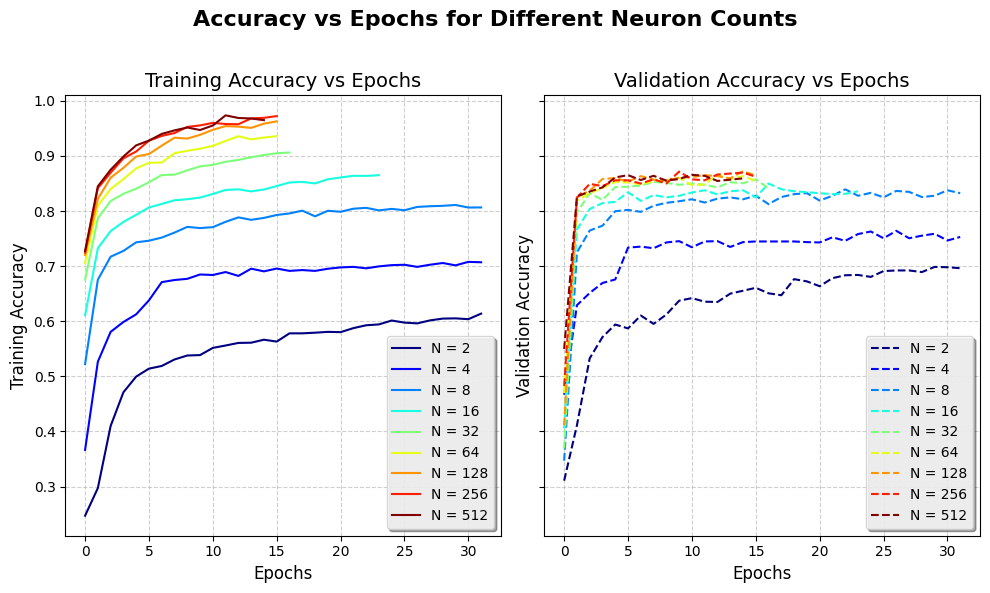

In [24]:
colors = plt.cm.jet(np.linspace(0, 1, len(N)))

fig, ax = plt.subplots(1, 2, figsize=(10, 6),sharey=True)

for i in range(len(N)):
    ax[0].plot(H[i].history['accuracy'], color=colors[i], label=f"N = {N[i]}")
    ax[1].plot(H[i].history['val_accuracy'], color=colors[i], label=f"N = {N[i]}", linestyle='--')

# Adding titles, labels, and grid
ax[0].set_title('Training Accuracy vs Epochs', fontsize=14)
ax[0].set_xlabel('Epochs', fontsize=12)
ax[0].set_ylabel('Training Accuracy', fontsize=12)
ax[0].grid(True, linestyle='--', alpha=0.6)

ax[1].set_title('Validation Accuracy vs Epochs', fontsize=14)
ax[1].set_xlabel('Epochs', fontsize=12)
ax[1].set_ylabel('Validation Accuracy', fontsize=12)
ax[1].grid(True, linestyle='--', alpha=0.6)

# Improving legend appearance
ax[0].legend(loc='best', shadow=True, fontsize=10, frameon=True, facecolor='white', framealpha=0.8)
ax[1].legend(loc='best', shadow=True, fontsize=10, frameon=True, facecolor='white', framealpha=0.8)

# Adding a global title
fig.suptitle('Accuracy vs Epochs for Different Neuron Counts', fontsize=16, fontweight='bold')

# Adjusting layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.show()


Note that the model converges faster as \( N \) increases, since there are more parameters to adjust. However, we do not observe overfitting, partly thanks to the EarlyStopping regularizer. Additionally, in the figure below, we can see that there is an \( N = 16 \) where the accuracy on the validation data does not increase significantly. Therefore, we chose this value of \( N \), as it represents the simplest model with excellent approximation performance.

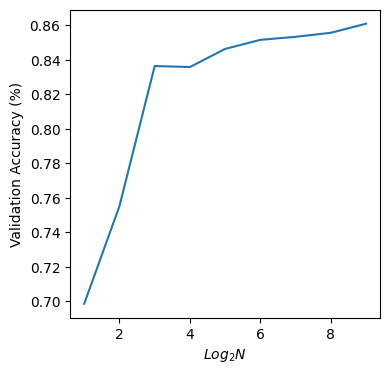

In [26]:
plt.figure(figsize=(4,4),dpi=100)
plt.xlabel("$Log_2 N$")
plt.ylabel('Validation Accuracy (%)')
plt.plot(np.log2(N),np.array(S)[:,1])
plt.show()

### Training our best MLP

In [27]:
n_neurons = 32
n_hidden_layers=1
num_classes=8
batch_size=64
epochs=32
opt='adam'
  #defining model
model = Sequential()
model.add(Flatten(input_shape=(28,28,3)))
model.add(BatchNormalization())
for i in range(n_hidden_layers):
  model.add(Dense(n_neurons, activation='relu'))
  model.add(Dropout(0.1))
model.add(Dense(num_classes, activation='softmax'))
# Compiling
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
# Regularization with early stopping
early_stopping = EarlyStopping(patience=10,min_delta=0.001,restore_best_weights=True,)
# Fit and saving results
history = model.fit(X_train, y_train,
                  batch_size=batch_size,
                  epochs=epochs,
                  verbose=0,
                  validation_data=(X_val, y_val),
                  callbacks=[early_stopping])
scores = model.evaluate(X_val, y_val, verbose=0)
print('Acurácia:' + str(scores))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Acurácia:[0.40242043137550354, 0.8528037667274475]


107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Text(0.5, 81.72222222222219, 'Predicted Class')

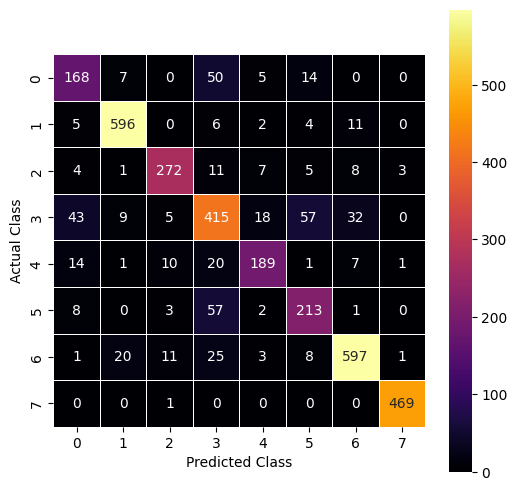

In [32]:
#Building confusion matrix
y_prediction = model.predict(X_test)
y_prediction = np.argmax (y_prediction, axis = 1)
y_test_cm=np.argmax(y_test, axis=1)

cm = metrics.confusion_matrix(y_test_cm, y_prediction )

# Assuming you have a confusion matrix named 'cm'
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square=True, cmap='inferno')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')

For this configuration, we achieved a test accuracy of 85%. We observe that class 3 has the highest number of errors, as the model misclassifies a significant number of images from this class as classes 0, 4, 5, and 6.

## What about a 2 layered percepetron?

In [33]:
N = np.array([2,4,8,16,32,64,128,256,512])

S = []
H = []

for n_neurons in N:
  print('Number of Neurons:' + str(n_neurons))
  s, h = MLP_v2(X_train,y_train,X_val,y_val,n_neurons=n_neurons,n_hidden_layers=2,opt='adam')
  S.append(s)
  H.append(h)

Number of Neurons:2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Number of Neurons:4
Number of Neurons:8
Number of Neurons:16
Number of Neurons:32
Number of Neurons:64
Number of Neurons:128
Number of Neurons:256
Number of Neurons:512


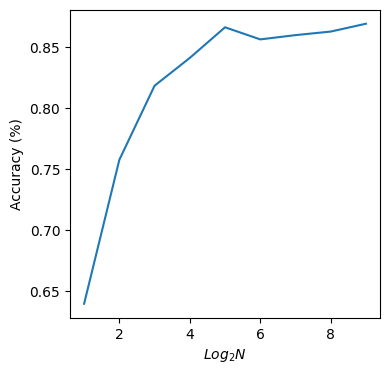

In [34]:
plt.figure(figsize=(4,4),dpi=100)
plt.xlabel("$Log_2 N$")
plt.ylabel('Accuracy (%)')
plt.plot(np.log2(N),np.array(S)[:,1])
plt.show()

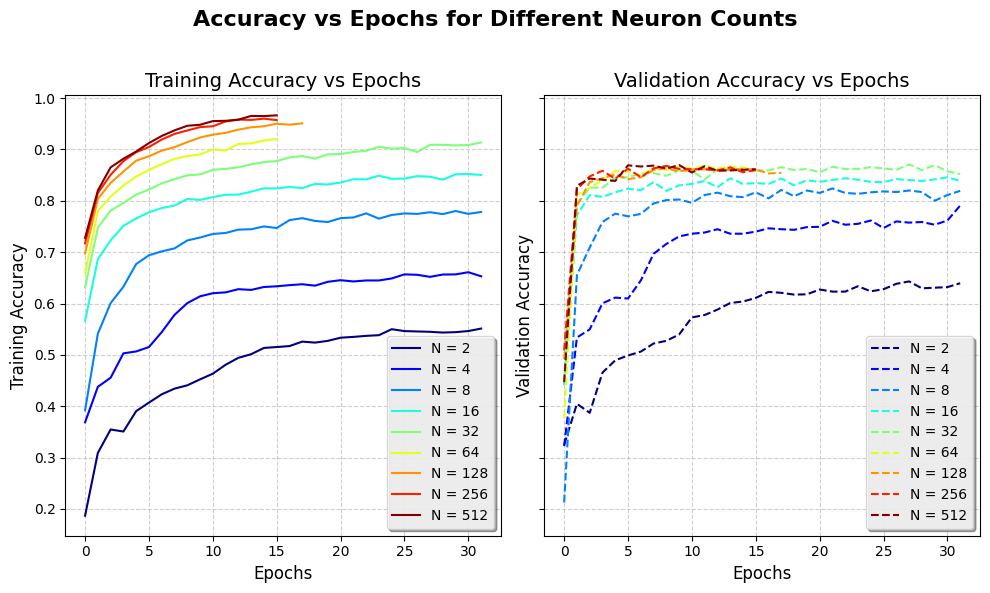

In [35]:
colors = plt.cm.jet(np.linspace(0, 1, len(N)))

fig, ax = plt.subplots(1, 2, figsize=(10, 6),sharey=True)

for i in range(len(N)):
    ax[0].plot(H[i].history['accuracy'], color=colors[i], label=f"N = {N[i]}")
    ax[1].plot(H[i].history['val_accuracy'], color=colors[i], label=f"N = {N[i]}", linestyle='--')

# Adding titles, labels, and grid
ax[0].set_title('Training Accuracy vs Epochs', fontsize=14)
ax[0].set_xlabel('Epochs', fontsize=12)
ax[0].set_ylabel('Training Accuracy', fontsize=12)
ax[0].grid(True, linestyle='--', alpha=0.6)

ax[1].set_title('Validation Accuracy vs Epochs', fontsize=14)
ax[1].set_xlabel('Epochs', fontsize=12)
ax[1].set_ylabel('Validation Accuracy', fontsize=12)
ax[1].grid(True, linestyle='--', alpha=0.6)

# Improving legend appearance
ax[0].legend(loc='best', shadow=True, fontsize=10, frameon=True, facecolor='white', framealpha=0.8)
ax[1].legend(loc='best', shadow=True, fontsize=10, frameon=True, facecolor='white', framealpha=0.8)

# Adding a global title
fig.suptitle('Accuracy vs Epochs for Different Neuron Counts', fontsize=16, fontweight='bold')

# Adjusting layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.show()

### Training our best 2 layered percepetron

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Accuracy:0.8568925261497498
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Text(0.5, 81.72222222222219, 'Predicted Class')

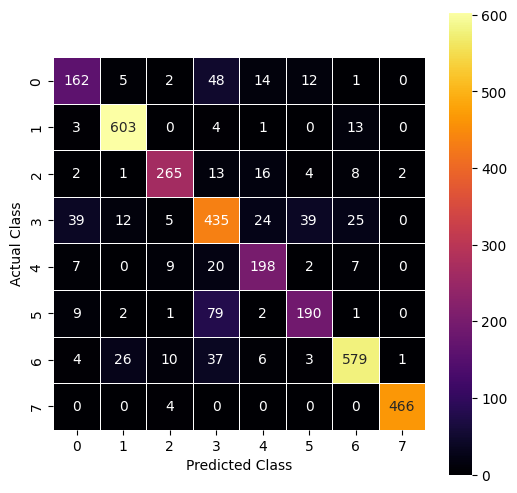

In [37]:
n_neurons = 64
n_hidden_layers=2
num_classes=8
batch_size=64
epochs=32
opt='adam'
  #defining model
model = Sequential()
model.add(Flatten(input_shape=(28,28,3)))
model.add(BatchNormalization())
for i in range(n_hidden_layers):
  model.add(Dense(n_neurons, activation='relu'))
  model.add(Dropout(0.1))
model.add(Dense(num_classes, activation='softmax'))
# Compiling
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
# Regularization with early stopping
early_stopping = EarlyStopping(patience=10,min_delta=0.001,restore_best_weights=True,)
# Fit and saving results
history = model.fit(X_train, y_train,
                  batch_size=batch_size,
                  epochs=epochs,
                  verbose=0,
                  validation_data=(X_val, y_val),
                  callbacks=[early_stopping])
scores = model.evaluate(X_val, y_val, verbose=0)
print('Accuracy:' + str(scores[1]))
  #Matriz de confusão
y_prediction = model.predict(X_test)
y_prediction = np.argmax (y_prediction, axis = 1)
y_test_cm=np.argmax(y_test, axis=1)

cm = metrics.confusion_matrix(y_test_cm, y_prediction )

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'inferno')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')

We get very similar results to the single layer percepetron.

## Classification using CNNs
### Defining function for testing the CNN
Here we set filters, kernel size, pool size, and optimizers.

In [39]:
def CNN_test(X_tr,Y_tr,X_val,Y_val,n_filters,kernel_size, pool_size,opt,num_classes=8,batch_size=128,epochs=50):
    model = Sequential()
    model.add(Conv2D(filters=n_filters, kernel_size=(kernel_size,kernel_size), padding='same', activation='relu', input_shape=(28, 28, 3)))
    model.add(MaxPooling2D(pool_size=(pool_size,pool_size), strides=(1, 1), padding='same'))
    model.add(Flatten())
    model.add(Dense(num_classes, activation='softmax'))
    # Compiling
    model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
    # Regularization with early stopping
    early_stopping = EarlyStopping(patience=6,min_delta=0.01,restore_best_weights=True,)
    # Fit and saving results
    history = model.fit(X_train, y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      verbose=1,
                      validation_data=(X_val, y_val),
                      callbacks=[early_stopping]
              )
    scores = model.evaluate(X_val, y_val, verbose=0)

    return scores, history

### Testing optimizers

In [40]:
OPT = ['sgd','adam']

S = []
H = []

for opt in OPT:
  print(str(opt))
  s, h = CNN_test(X_train,y_train,X_val,y_val,n_filters=32, kernel_size=3,pool_size=3,opt=opt)
  S.append(s)
  H.append(h)

sgd


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.2902 - loss: 1.8833 - val_accuracy: 0.4667 - val_loss: 1.5151
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4686 - loss: 1.4487 - val_accuracy: 0.4089 - val_loss: 1.6171
Epoch 3/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5817 - loss: 1.1791 - val_accuracy: 0.5754 - val_loss: 1.0544
Epoch 4/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6035 - loss: 1.0701 - val_accuracy: 0.6583 - val_loss: 0.9882
Epoch 5/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6601 - loss: 0.9687 - val_accuracy: 0.5479 - val_loss: 1.0023
Epoch 6/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6668 - loss: 0.9219 - val_accuracy: 0.7225 - val_loss: 0.8240
Epoch 7/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7034 - loss: 0.8278 - val_accuracy: 0.7436 - val_loss: 0.7465
Epoch 8/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7163 - loss: 0.8092 - val_accuracy: 0.7290 - val_loss

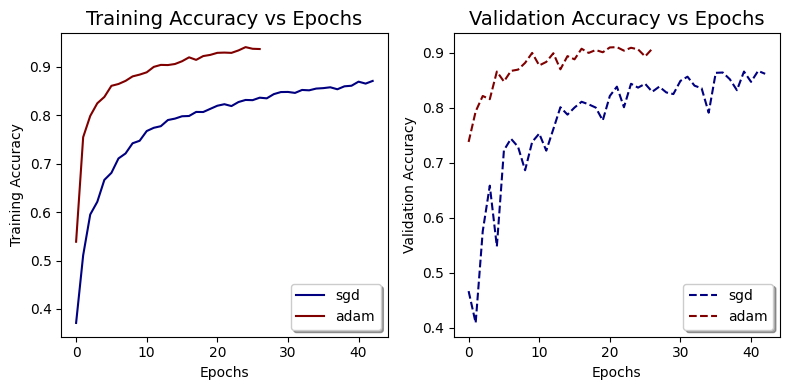

In [41]:
colors = plt.cm.jet(np.linspace(0,1,len(OPT)))

fig, ax = plt.subplots(1,2,figsize=(8,4),dpi=100)
for i in range(len(OPT)):
  ax[0].plot(H[i].history['accuracy'], color=colors[i], label=str(OPT[i]))
  ax[1].plot(H[i].history['val_accuracy'], color=colors[i], label=str(OPT[i]),ls='--')
ax[0].legend(loc='best', shadow=True)
ax[1].legend(loc='best', shadow=True)
ax[0].set_title('Training Accuracy vs Epochs', fontsize=14)
ax[1].set_title('Validation Accuracy vs Epochs', fontsize=14)

ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs')
ax[0].set_ylabel('Training Accuracy')
ax[1].set_ylabel('Validation Accuracy')
plt.tight_layout()
plt.show()

As we can observe, the Adam optimizer exhibits both faster convergence and better performance compared to SGD. The reason for this has already been elaborated upon in the MLP, where we attributed this better optimization to the fact that Adam uses an algorithm that carries momentum with an adaptive step size, and therefore, does not get stuck in a "zig-zag" trajectory on the cost function contours. Therefore, despite the known good performance of SGD for image classification tasks (Wilson, 2018), we chose to use Adam.

### Testing number of Kernels

In [46]:
K = np.array([4,16,32,128,512,1024,2048])

S = []
H = []

for n_filters in K:
  print('Number of Kernels:' + str(n_filters))
  s, h = CNN_test(X_train,y_train,X_val,y_val,n_filters=n_filters, kernel_size=3,opt='adam',pool_size=3)
  S.append(s)
  H.append(h)

Number of Kernels:4


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.3657 - loss: 1.7750 - val_accuracy: 0.6343 - val_loss: 0.9984
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6938 - loss: 0.9009 - val_accuracy: 0.7407 - val_loss: 0.7555
Epoch 3/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7365 - loss: 0.7735 - val_accuracy: 0.7243 - val_loss: 0.7840
Epoch 4/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7364 - loss: 0.7476 - val_accuracy: 0.7646 - val_loss: 0.6787
Epoch 5/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7658 - loss: 0.6773 - val_accuracy: 0.7675 - val_loss: 0.6708
Epoch 6/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7861 - loss: 0.6479 - val_accuracy: 0.7745 - val_loss: 0.6636
Epoch 7/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7820 - loss: 0.6550 - val_accuracy: 0.7862 - val_loss: 0.6265
Epoch 8/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7997 - loss: 0.6012 - val_accuracy: 0.7891 - val_loss

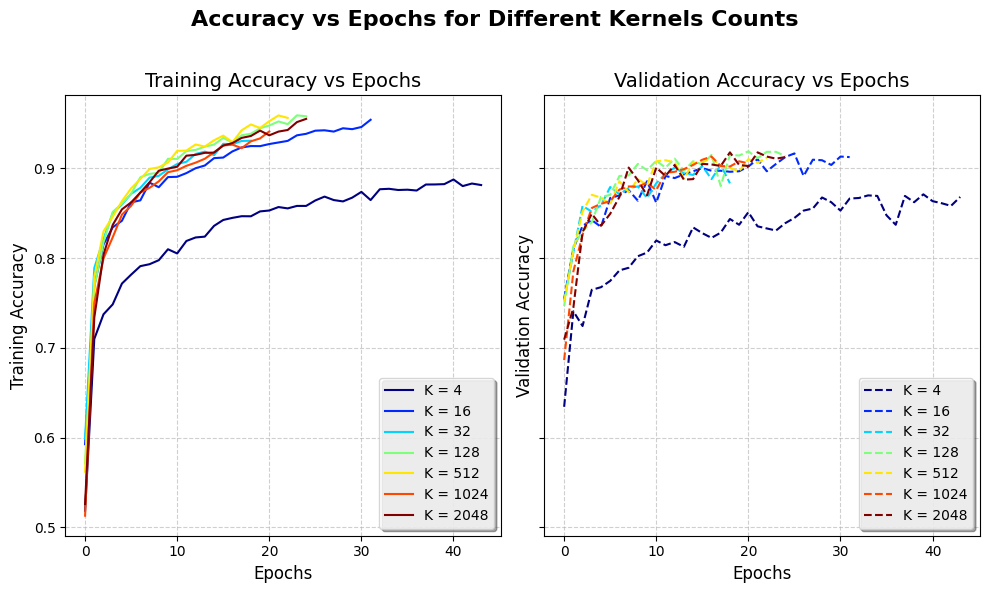

In [47]:
colors = plt.cm.jet(np.linspace(0,1,len(K)))

fig, ax = plt.subplots(1, 2, figsize=(10, 6),sharey=True)

for i in range(len(K)):
    ax[0].plot(H[i].history['accuracy'], color=colors[i], label=f"K = {K[i]}")
    ax[1].plot(H[i].history['val_accuracy'], color=colors[i], label=f"K = {K[i]}", linestyle='--')

# Adding titles, labels, and grid
ax[0].set_title('Training Accuracy vs Epochs', fontsize=14)
ax[0].set_xlabel('Epochs', fontsize=12)
ax[0].set_ylabel('Training Accuracy', fontsize=12)
ax[0].grid(True, linestyle='--', alpha=0.6)

ax[1].set_title('Validation Accuracy vs Epochs', fontsize=14)
ax[1].set_xlabel('Epochs', fontsize=12)
ax[1].set_ylabel('Validation Accuracy', fontsize=12)
ax[1].grid(True, linestyle='--', alpha=0.6)

# Improving legend appearance
ax[0].legend(loc='best', shadow=True, fontsize=10, frameon=True, facecolor='white', framealpha=0.8)
ax[1].legend(loc='best', shadow=True, fontsize=10, frameon=True, facecolor='white', framealpha=0.8)

# Adding a global title
fig.suptitle('Accuracy vs Epochs for Different Kernels Counts', fontsize=16, fontweight='bold')

# Adjusting layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.show()

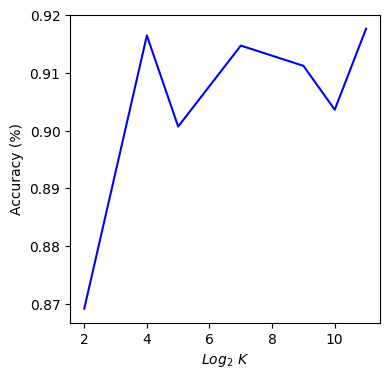

In [48]:
plt.figure(figsize=(4,4),dpi=100)
plt.xlabel("$Log_2$ $K$")
plt.ylabel('Accuracy (%)')
plt.plot(np.log2(K),np.array(S)[:,1],color='blue')
plt.show()

Optimal kernel number is 16 (for a kernel size=3).

### Optimizing kernel size

In [50]:
K = np.array([1,2,3,4,5,10])

S = []
H = []

for k_size in K:
  print('Number of Kernels:' + str(k_size))
  s, h = CNN_test(X_train,y_train,X_val,y_val,n_filters=16, kernel_size=k_size,opt='adam',pool_size=3)
  S.append(s)
  H.append(h)

Number of Kernels:1
Epoch 1/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.4087 - loss: 1.6182 - val_accuracy: 0.7576 - val_loss: 0.7263
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7869 - loss: 0.6742 - val_accuracy: 0.8172 - val_loss: 0.5527
Epoch 3/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8181 - loss: 0.5646 - val_accuracy: 0.8324 - val_loss: 0.5108
Epoch 4/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8335 - loss: 0.5152 - val_accuracy: 0.8458 - val_loss: 0.4838
Epoch 5/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8364 - loss: 0.4944 - val_accuracy: 0.8598 - val_loss: 0.4333
Epoch 6/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8548 - loss: 0.4443 - val_accuracy: 0.8645 - val_loss: 0.4177
Epoch 7/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8598 - loss: 0.4264 - val_accuracy: 0.8516 - val_loss: 0.4182
Epoch 8/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8611 - loss: 0.4066 - val_accurac

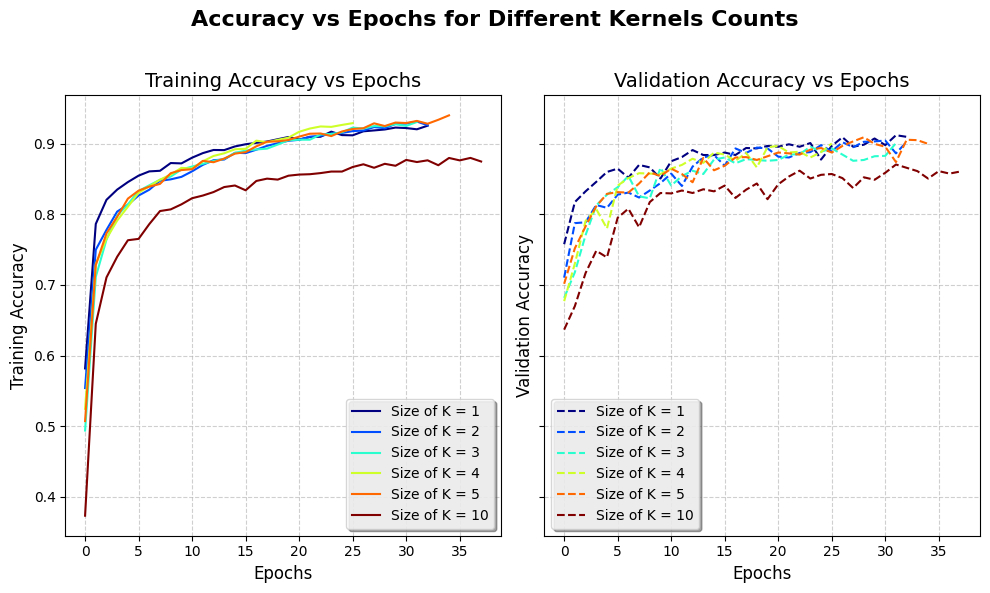

In [51]:
colors = plt.cm.jet(np.linspace(0,1,len(K)))

fig, ax = plt.subplots(1, 2, figsize=(10, 6),sharey=True)

for i in range(len(K)):
    ax[0].plot(H[i].history['accuracy'], color=colors[i], label=f"Size of K = {K[i]}")
    ax[1].plot(H[i].history['val_accuracy'], color=colors[i], label=f"Size of K = {K[i]}", linestyle='--')

# Adding titles, labels, and grid
ax[0].set_title('Training Accuracy vs Epochs', fontsize=14)
ax[0].set_xlabel('Epochs', fontsize=12)
ax[0].set_ylabel('Training Accuracy', fontsize=12)
ax[0].grid(True, linestyle='--', alpha=0.6)

ax[1].set_title('Validation Accuracy vs Epochs', fontsize=14)
ax[1].set_xlabel('Epochs', fontsize=12)
ax[1].set_ylabel('Validation Accuracy', fontsize=12)
ax[1].grid(True, linestyle='--', alpha=0.6)

# Improving legend appearance
ax[0].legend(loc='best', shadow=True, fontsize=10, frameon=True, facecolor='white', framealpha=0.8)
ax[1].legend(loc='best', shadow=True, fontsize=10, frameon=True, facecolor='white', framealpha=0.8)

# Adding a global title
fig.suptitle('Accuracy vs Epochs for Different Kernels Counts', fontsize=16, fontweight='bold')

# Adjusting layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.show()

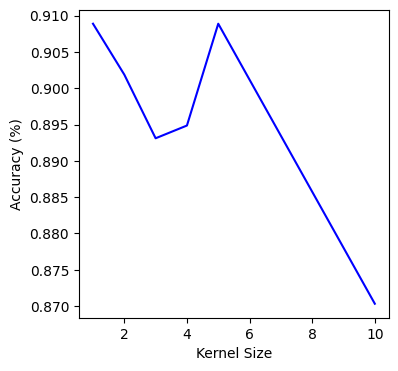

In [52]:
plt.figure(figsize=(4,4),dpi=100)
plt.xlabel("Kernel Size")
plt.ylabel('Accuracy (%)')
plt.plot(K,np.array(S)[:,1],color='blue')
plt.show()

The kernel size influences very little on the CNN performance. Maybe we can use kernel size = 1.

### Pooling size

In [54]:
K = np.array([1,3,5,7])

S = []
H = []

for p_size in K:
  print('Pooling size:' + str(k_size))
  s, h = CNN_test(X_train,y_train,X_val,y_val,n_filters=16, kernel_size=1,opt='adam',pool_size=p_size)
  S.append(s)
  H.append(h)

Pooling size:10
Epoch 1/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.4203 - loss: 1.5988 - val_accuracy: 0.6671 - val_loss: 0.9442
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6989 - loss: 0.8647 - val_accuracy: 0.7482 - val_loss: 0.7234
Epoch 3/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7624 - loss: 0.7273 - val_accuracy: 0.7950 - val_loss: 0.6416
Epoch 4/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7886 - loss: 0.6569 - val_accuracy: 0.8026 - val_loss: 0.6137
Epoch 5/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8064 - loss: 0.6085 - val_accuracy: 0.8137 - val_loss: 0.5750
Epoch 6/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8140 - loss: 0.5665 - val_accuracy: 0.8160 - val_loss: 0.5537
Epoch 7/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8223 - loss: 0.5491 - val_accuracy: 0.8277 - val_loss: 0.5379
Epoch 8/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8269 - loss: 0.5272 - val_accuracy: 0

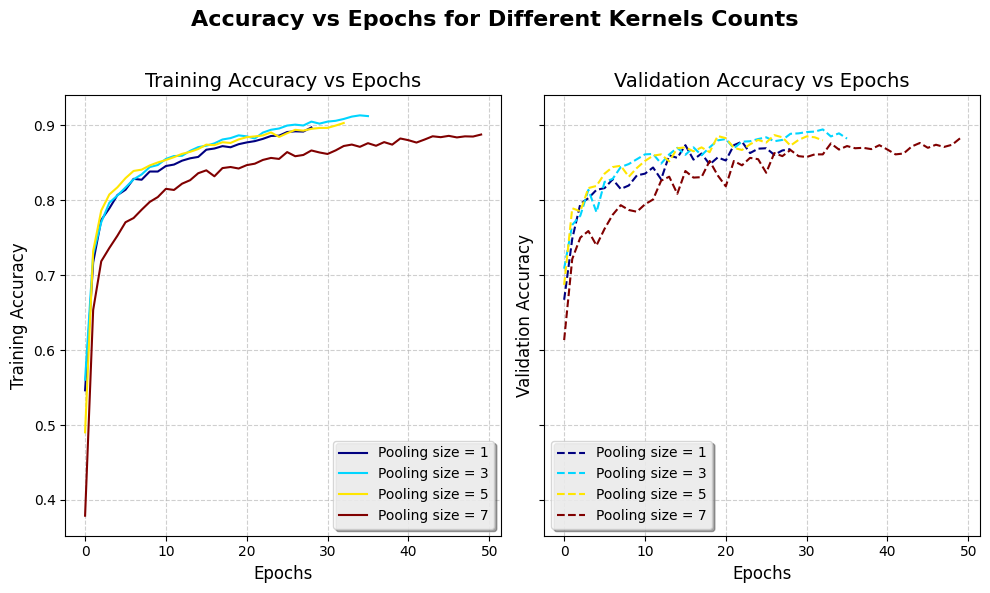

In [55]:
colors = plt.cm.jet(np.linspace(0,1,len(K)))

fig, ax = plt.subplots(1, 2, figsize=(10, 6),sharey=True)

for i in range(len(K)):
    ax[0].plot(H[i].history['accuracy'], color=colors[i], label=f"Pooling size = {K[i]}")
    ax[1].plot(H[i].history['val_accuracy'], color=colors[i], label=f"Pooling size = {K[i]}", linestyle='--')

# Adding titles, labels, and grid
ax[0].set_title('Training Accuracy vs Epochs', fontsize=14)
ax[0].set_xlabel('Epochs', fontsize=12)
ax[0].set_ylabel('Training Accuracy', fontsize=12)
ax[0].grid(True, linestyle='--', alpha=0.6)

ax[1].set_title('Validation Accuracy vs Epochs', fontsize=14)
ax[1].set_xlabel('Epochs', fontsize=12)
ax[1].set_ylabel('Validation Accuracy', fontsize=12)
ax[1].grid(True, linestyle='--', alpha=0.6)

# Improving legend appearance
ax[0].legend(loc='best', shadow=True, fontsize=10, frameon=True, facecolor='white', framealpha=0.8)
ax[1].legend(loc='best', shadow=True, fontsize=10, frameon=True, facecolor='white', framealpha=0.8)

# Adding a global title
fig.suptitle('Accuracy vs Epochs for Different Kernels Counts', fontsize=16, fontweight='bold')

# Adjusting layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.show()

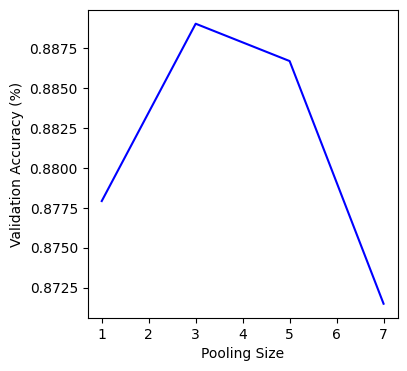

In [56]:
plt.figure(figsize=(4,4),dpi=100)
plt.xlabel("Pooling Size")
plt.ylabel('Validation Accuracy (%)')
plt.plot(K,np.array(S)[:,1],color='blue')
plt.show()

Optimal pooling size is between 3 and 5.

### Results for optimized CNN

In [57]:
#Optimized parameters
kernel_size = 1
filters = 16
pool_size_ = (4,4)
num_classes=8
batch_size=128
epochs=100
opt='adam'


#defining model
model = Sequential()
model.add(Conv2D(filters=filters, kernel_size=(kernel_size,kernel_size), padding='same', activation='relu', input_shape=(28, 28, 3)))
model.add(MaxPooling2D(pool_size=pool_size_, strides=(1, 1), padding='same'))
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))
# Compiling
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
# Regularization with early stopping
early_stopping = EarlyStopping(patience=10,min_delta=0.01,restore_best_weights=True,)
# Fit and saving results
history = model.fit(X_train, y_train,
                  batch_size=batch_size,
                  epochs=epochs,
                  verbose=1,
                  validation_data=(X_val, y_val),
                  callbacks=[early_stopping]
                  )

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.3372 - loss: 1.8928 - val_accuracy: 0.7307 - val_loss: 0.9112
Epoch 2/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7175 - loss: 0.8776 - val_accuracy: 0.7243 - val_loss: 0.8067
Epoch 3/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7479 - loss: 0.7578 - val_accuracy: 0.7512 - val_loss: 0.6919
Epoch 4/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7624 - loss: 0.7003 - val_accuracy: 0.7932 - val_loss: 0.6344
Epoch 5/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7814 - loss: 0.6351 - val_accuracy: 0.7979 - val_loss: 0.6042
Epoch 6/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7975 - loss: 0.6164 - val_accuracy: 0.8008 - val_loss: 0.5972
Epoch 7/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8074 - loss: 0.5857 - val_accuracy: 0.7903 - val_loss: 0.5925
Epoch 8/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7952 - loss: 0.5881 - val_accuracy: 0.7681 - 

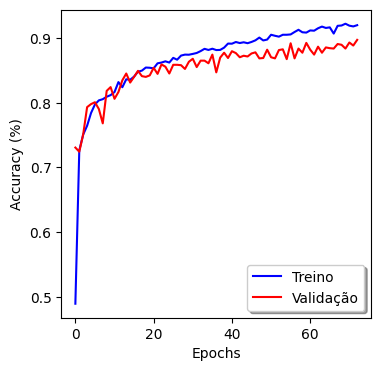

In [59]:
plt.figure(figsize=(4,4),dpi=100)
plt.plot(history.history['accuracy'], color='b', label="Treino")
plt.plot(history.history['val_accuracy'], color='r', label="Validação")
plt.legend(loc='best', shadow=True)
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.show()

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8794 - loss: 0.3515
Accuracy:[0.3311125934123993, 0.8827828168869019]
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Text(0.5, 137.22222222222217, 'Predicted Class')

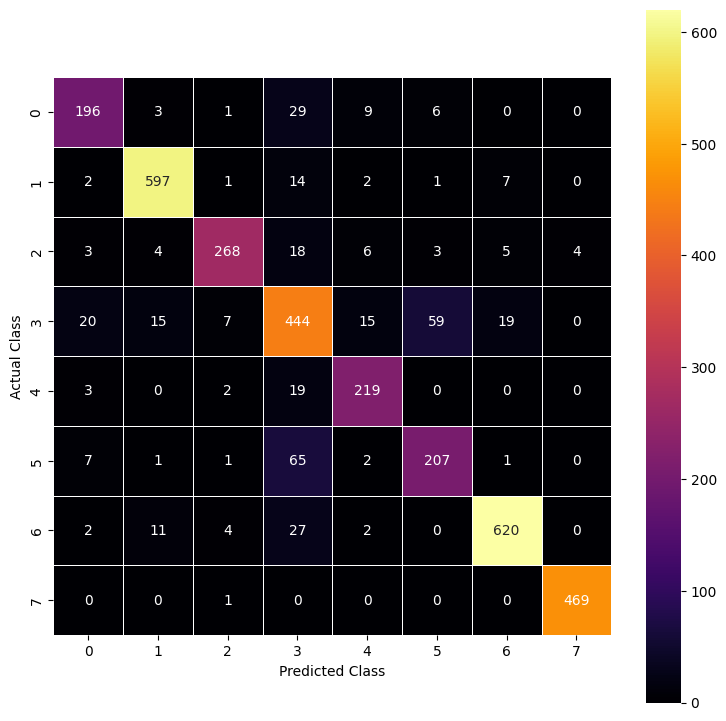

In [61]:
scores = model.evaluate(X_test, y_test, verbose=1)
print('Accuracy:' + str(scores))
  #Matriz de confusão
y_prediction_ = model.predict(X_test)
y_prediction = np.argmax (y_prediction_, axis = 1)
y_test_cm=np.argmax(y_test, axis=1)

cm = metrics.confusion_matrix(y_test_cm, y_prediction )

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'inferno')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')

Our accuracy with CNN was about 88% which is very decent! In principle, we could tune the hyperparameters further with automated techniques such as Random Search and so on.

## Checking on the incorrect predictions

In [75]:
    cell_types = [
        "Basophils",        # 0
        "Eosinophils",      # 1
        "Erythroblasts",    # 2
        "Immature Granulocytes",  # 3
        "Lymphocytes",      # 4
        "Monocytes",        # 5
        "Neutrophils",      # 6
        "Platelets"         # 7
    ]

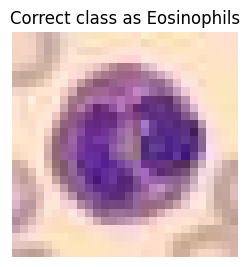

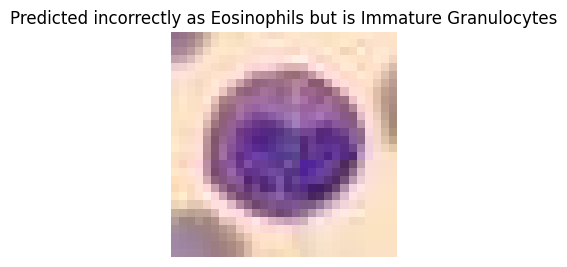

In [84]:
np.set_printoptions(precision=2)
classe = 1
plt.figure()
for i in range(y_test_cm.size):
  if classe == y_test_cm[i] and y_prediction[i]==y_test_cm[i]:
    plt.subplot(121)
    plt.title('Correct class as '+cell_types[classe])
    plt.imshow(X_test[i].reshape(28,28,3), cmap=plt.cm.binary)
    plt.axis(False)
    plt.show()
    break


for i in range(y_test_cm.size):
  if classe == y_test_cm[i] and y_prediction[i]!=y_test_cm[i]:
    plt.subplot(122)
    plt.title('Predicted incorrectly as '+cell_types[classe] + ' but is '+ cell_types[y_prediction[i]])
    plt.imshow(X_test[i].reshape(28,28,3), cmap=plt.cm.binary)
    plt.axis(False)
    plt.show()

    break


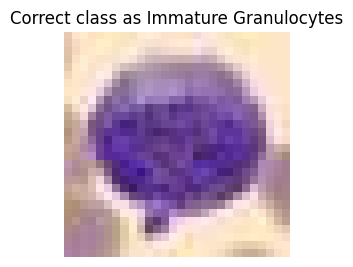

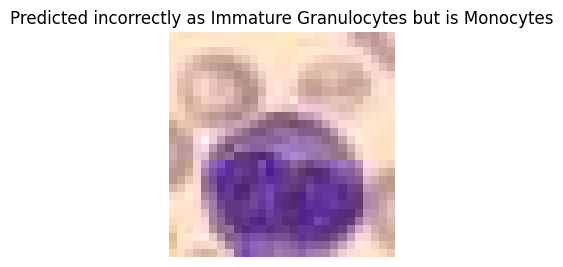

In [85]:
np.set_printoptions(precision=2)
classe = 3
plt.figure()
for i in range(y_test_cm.size):
  if classe == y_test_cm[i] and y_prediction[i]==y_test_cm[i]:
    plt.subplot(121)
    plt.title('Correct class as '+cell_types[classe])
    plt.imshow(X_test[i].reshape(28,28,3), cmap=plt.cm.binary)
    plt.axis(False)
    plt.show()
    break


for i in range(y_test_cm.size):
  if classe == y_test_cm[i] and y_prediction[i]!=y_test_cm[i]:
    plt.subplot(122)
    plt.title('Predicted incorrectly as '+cell_types[classe] + ' but is '+ cell_types[y_prediction[i]])
    plt.imshow(X_test[i].reshape(28,28,3), cmap=plt.cm.binary)
    plt.axis(False)
    plt.show()

    break

Visually speaking, as an untrained human, these cells look very similar and the mistakes are very comprehensible.

## Conclusion

In this study, we compared the performance of Multilayer Perceptrons (MLPs) and Convolutional Neural Networks (CNNs) for classifying images of blood cells. Our findings demonstrate that CNNs significantly outperform MLPs on this task, achieving a peak accuracy of 88%. This superior performance can be attributed to CNNs' ability to automatically learn and extract relevant features from image data, making them particularly well-suited for tasks involving spatial relationships.

While the current accuracy is promising, there is still room for improvement. Advanced hyperparameter tuning techniques, such as grid search or Bayesian optimization, could potentially further enhance the model's performance. Additionally, exploring different CNN architectures and data augmentation strategies might yield even better results.

Furthermore, our analysis of the model's errors revealed that many of the misclassifications were understandable and could be attributed to the inherent complexity of the task. For instance, some blood cells exhibit subtle morphological variations that can be challenging even for human experts to differentiate. Addressing these challenges will require further research and the development of more sophisticated models.